# Notebook 04 — Model Training & Evaluation

This notebook:

1. Builds a **supervised learning dataset** from the processed stress index
   (`data/processed/stress_index.csv`) and labels (`data/processed/stress_labels.csv`).
2. Splits the data into **time-ordered train / test sets**.
3. Trains a **logistic-regression baseline model**.
4. Evaluates performance (ROC AUC, average precision, accuracy, precision, recall).
5. Plots **predicted stress probabilities vs actual stress days**.
6. Saves the trained model and metrics under `results/models/`.

The notebook uses the helper functions defined in:

- `src/bank_stress/models.py`
- `build_ml_dataset`, `train_test_split_by_date`,
  `train_baseline_logit`, and `evaluate_model`.

In [1]:
#!/usr/bin/env python3
"""
Notebook 04 — Model Training & Evaluation.

This cell:
- Sets the working directory to the project root
- Makes `src/` importable as a package
- Imports the modeling utilities from `bank_stress.models`
"""

import json
import os
import sys
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# The notebook lives in <project_root>/notebooks,
# so the project root is the parent directory of the current one.
note_book_dir = Path.cwd()
project_root = note_book_dir.parent

# Change working directory so that relative paths (data/, results/, …)
# are resolved from the project root.
os.chdir(project_root)

# Ensure src/ is on sys.path so that we can import bank_stress.*
src_dir = project_root / "src"
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

print("Running from:", Path.cwd())
print("SRC_DIR:", src_dir)

from bank_stress.models import (  # noqa: E402
    DatasetPaths,
    build_ml_dataset,
    evaluate_model,
    train_baseline_logit,
    train_test_split_by_date,
)

Running from: /files/bank_stress_detection_project_datascience_class
SRC_DIR: /files/bank_stress_detection_project_datascience_class/src


In [2]:
"""
Set up file paths and high-level modeling parameters.
"""

processed_dir = project_root / "data" / "processed"
results_dir = project_root / "results"
results_dir.mkdir(parents=True, exist_ok=True)

model_dir = results_dir / "models"
model_dir.mkdir(parents=True, exist_ok=True)

stress_index_path = processed_dir / "stress_index.csv"
labels_path = processed_dir / "stress_labels.csv"  # main specification

if not stress_index_path.exists():
    raise FileNotFoundError("Missing stress_index.csv — run Notebook 02 first.")
if not labels_path.exists():
    raise FileNotFoundError("Missing stress_labels.csv — run Notebook 03 first.")

print("Stress index path:", stress_index_path)
print("Labels path:      ", labels_path)

# Modeling hyperparameters
LAGS = 5  # how many lagged values of the stress index to use as features
SPLIT_DATE = "2018-01-01"  # time-based train/test split boundary (inclusive for test set)

Stress index path: /files/bank_stress_detection_project_datascience_class/data/processed/stress_index.csv
Labels path:       /files/bank_stress_detection_project_datascience_class/data/processed/stress_labels.csv


In [3]:
"""
Build the supervised dataset from processed CSV files.

- x_data: feature matrix (DataFrame)
- y_data: binary labels (Series)
"""

dataset_paths = DatasetPaths(
    stress_index_path=stress_index_path,
    labels_path=labels_path,
)

x_data, y_data = build_ml_dataset(paths=dataset_paths, lags=LAGS)

print("\n=== Dataset Overview ===")
print("X shape:", x_data.shape)
print("y shape:", y_data.shape)
print("Date range:", x_data.index.min(), "→", x_data.index.max())
print("Fraction stress days:", float(y_data.mean().round(4)))

# In a notebook, display() gives a nice HTML table; fall back to print if unavailable.
try:
    display(x_data.head())
except Exception:  # pragma: no cover - only for non-notebook runs
    print(x_data.head().to_string())


=== Dataset Overview ===
X shape: (2349, 8)
y shape: (2349,)
Date range: 2000-01-12 05:00:00 → 2025-11-21 05:00:00
Fraction stress days: 0.0502


,avg_vol,avg_corr,stress_index_smooth,stress_index_smooth_lag1,stress_index_smooth_lag2,stress_index_smooth_lag3,stress_index_smooth_lag4,stress_index_smooth_lag5
Date,,,,,,,,
2000-01-12 05:00:00,0.034752,0.710793,0.724513,0.816607,0.925065,1.028803,1.074678,1.041222
2000-01-13 05:00:00,0.035988,0.680299,0.637625,0.724513,0.816607,0.925065,1.028803,1.074678
2000-01-14 05:00:00,0.035576,0.671228,0.560377,0.637625,0.724513,0.816607,0.925065,1.028803
2000-01-18 05:00:00,0.035929,0.641691,0.483049,0.560377,0.637625,0.724513,0.816607,0.925065
2000-01-19 05:00:00,0.035120,0.593880,0.392091,0.483049,0.560377,0.637625,0.724513,0.816607


In [4]:
"""
Split the dataset into time-ordered train and test sets.

We use a calendar date (SPLIT_DATE) as the boundary:
- observations strictly before SPLIT_DATE go to the train set
- observations on/after SPLIT_DATE go to the test set
"""

x_train, x_test, y_train, y_test = train_test_split_by_date(
    features=x_data,
    labels=y_data,
    split_date=SPLIT_DATE,
)

print("\n=== Train/Test Split ===")
print("Train rows:", len(x_train))
print("Test rows :", len(x_test))
print("Train stress share:", float(y_train.mean().round(4)))
print("Test stress share : ", float(y_test.mean().round(4)))
print("Train period:", x_train.index.min(), "→", x_train.index.max())
print("Test period : ", x_test.index.min(), "→", x_test.index.max())


=== Train/Test Split ===
Train rows: 1688
Test rows : 661
Train stress share: 0.0634
Test stress share :  0.0166
Train period: 2000-01-12 05:00:00 → 2017-12-29 05:00:00
Test period :  2018-01-02 05:00:00 → 2025-11-21 05:00:00


In [5]:
"""
Train a simple logistic-regression baseline model.

train_baseline_logit returns a fitted sklearn Pipeline:
    StandardScaler -> LogisticRegression(class_weight='balanced')
"""

baseline_model = train_baseline_logit(
    features_train=x_train,
    labels_train=y_train,
    c_param=1.0,  # mapped to LogisticRegression(C=1.0) inside the function
    solver="lbfgs",
    random_state=0,
)

print("\nModel trained.")
print(baseline_model)


Model trained.
Pipeline(steps=[('scaler', StandardScaler()),
                ('logit',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=0))])


In [6]:
"""
Evaluate the fitted model on the test set.

The evaluate_model function:
- computes ROC AUC, average precision, accuracy, precision (class 1), recall (class 1)
- prints a classification report
- returns a metrics dictionary
"""

metrics_dict = evaluate_model(
    model=baseline_model,
    features_test=x_test,
    labels_test=y_test,
)

print("\n=== Metrics summary ===")
for metric_name, metric_value in metrics_dict.items():
    if (
        metric_value is not None
        and not (isinstance(metric_value, float) and np.isnan(metric_value))
    ):
        print(f"{metric_name:>12}: {metric_value:.3f}")
    else:
        print(f"{metric_name:>12}: {metric_value}")


=== Test set metrics ===
     roc_auc: 1.000
avg_precision: 1.000
    accuracy: 0.986
 precision_1: 0.550
    recall_1: 1.000

=== Classification report ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       650
           1       0.55      1.00      0.71        11

    accuracy                           0.99       661
   macro avg       0.78      0.99      0.85       661
weighted avg       0.99      0.99      0.99       661


=== Metrics summary ===
     roc_auc: 1.000
avg_precision: 1.000
    accuracy: 0.986
 precision_1: 0.550
    recall_1: 1.000


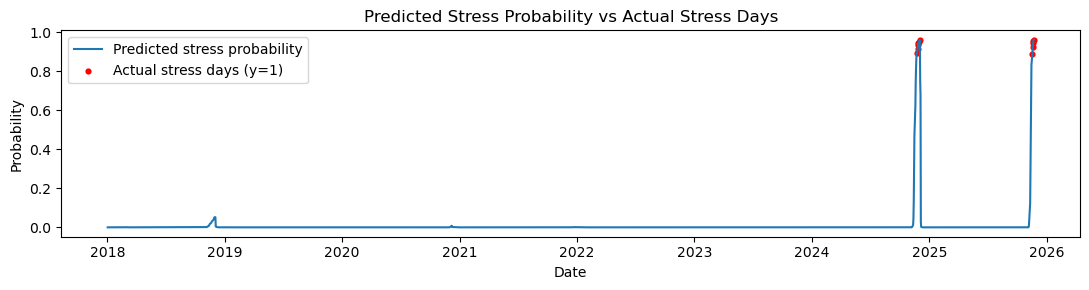

In [8]:
"""
Plot predicted stress probabilities against time,
highlighting days where y_test == 1 (stress days).

We try:
 1. model.predict_proba
 2. model.decision_function rescaled to [0, 1]
If neither is available, we skip the plot.
"""

predicted_probabilities = None

# First preference: use predicted probabilities for the positive class.
try:
    predicted_probabilities = baseline_model.predict_proba(x_test)[:, 1]
except Exception:  # pragma: no cover - defensive fallback
    # Second preference: use decision_function and rescale to [0, 1].
    try:
        decision_scores = baseline_model.decision_function(x_test)
        decision_scores = np.asarray(decision_scores).ravel()
        min_score, max_score = decision_scores.min(), decision_scores.max()
        if max_score > min_score:
            predicted_probabilities = (decision_scores - min_score) / (
                max_score - min_score
            )
        else:
            predicted_probabilities = np.zeros_like(decision_scores)
    except Exception:  # pragma: no cover - last resort
        predicted_probabilities = None

if predicted_probabilities is not None:
    stress_mask = np.asarray(y_test == 1)

    fig, axis = plt.subplots(figsize=(11, 3))
    axis.plot(
        x_test.index,
        predicted_probabilities,
        label="Predicted stress probability",
    )
    axis.scatter(
        x_test.index[stress_mask],
        predicted_probabilities[stress_mask],
        color="red",
        s=12,
        label="Actual stress days (y=1)",
    )
    axis.set_title("Predicted Stress Probability vs Actual Stress Days")
    axis.set_xlabel("Date")
    axis.set_ylabel("Probability")
    axis.legend()
    fig.tight_layout()

    fig_path = results_dir / "figures" / "predicted_stress_probabilities.png"
    fig.savefig(fig_path, dpi=300)
    
    plt.show()
else:
    print(
        "predict_proba / decision_function not available — "
        "skipping probability plot.",
    )

In [9]:
"""
Save the trained model (joblib) and the evaluation metrics (JSON).

JSON cannot represent NaN/inf, so we sanitize the metrics dictionary:
- convert numpy scalars to Python scalars
- replace NaN/inf with None
"""

model_path = model_dir / "baseline_logit.joblib"
metrics_path = model_dir / "baseline_logit_metrics.json"


def sanitize_for_json(obj: object) -> object:
    """Recursively convert metrics dict into something JSON can handle."""
    if isinstance(obj, dict):
        return {key: sanitize_for_json(value) for key, value in obj.items()}

    # Replace NaN / inf with None
    if isinstance(obj, float) and (np.isnan(obj) or np.isinf(obj)):
        return None

    # Handle numpy scalar types (float32, int64, etc.)
    try:
        if np.isscalar(obj):
            if isinstance(obj, (float, np.floating)):
                return float(obj)
            if isinstance(obj, (int, np.integer)):
                return int(obj)
    except Exception:  # pragma: no cover - extremely defensive
        pass

    return obj


joblib.dump(baseline_model, model_path)

metrics_for_json = sanitize_for_json(metrics_dict)
with metrics_path.open("w", encoding="utf-8") as file_handle:
    json.dump(metrics_for_json, file_handle, indent=2, ensure_ascii=False)

print("\nSaved model to :", model_path)
print("Saved metrics to:", metrics_path)
print("\nNotebook 04 finished successfully.")


Saved model to : /files/bank_stress_detection_project_datascience_class/results/models/baseline_logit.joblib
Saved metrics to: /files/bank_stress_detection_project_datascience_class/results/models/baseline_logit_metrics.json

Notebook 04 finished successfully.
